# Multi-armed Bandits for Component Permutations

### Load Data

In [6]:
import os
import pandas as pd
import itertools
import seaborn
import math
from matplotlib import pyplot
from scipy import std, mean
from scipy.stats import mode, kurtosis, skew
from numpy import median
import random
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import statistics
import pickle

frames = []

for root, dirs, files in os.walk("data"):
    for f in files:
        if f.endswith(".csv"):
            file_path = os.path.join(root, f)
            dataframe = pd.read_csv(file_path)
            dataframe.columns=dataframe.columns.str.replace('\t','')
            frames.append(dataframe)

data = pd.concat(frames, sort=False)[['Optimal_Affected_Component', 'Optimal_Failure', 'Optimal_Rule', 'Optimal_Utility_Increase', ]]
data

,Optimal_Affected_Component,Optimal_Failure,Optimal_Rule,Optimal_Utility_Increase
0,Query Service,CF1,RestartComponent,49.500000
1,User Management Service,CF2,RestartComponent,16.000000
2,Authentication Service,CF3,ReplaceComponent,31.500000
3,Bid and Buy Service,CF3,HwRedeployComponent,25.000000
4,Item Management Service,CF3,HwRedeployComponent,16.000000
...,...,...,...,...
639,Item Management Service,CF5,AddReplica,96.463006
640,Reputation Service,CF5,AddReplica,194.654318
641,Item Management Service,CF1,RestartComponent,119.123303
642,Last Second Sales Item Filter,CF2,RestartComponent,96.674251


### Bandit and Simulation Class

In [19]:
def lazy_property(fn):
    '''Decorator that makes a property lazy-evaluated.'''
    attr_name = '_lazy_' + fn.__name__

    @property
    def _lazy_property(self):
        if not hasattr(self, attr_name):
            setattr(self, attr_name, fn(self))
        return getattr(self, attr_name)
    return _lazy_property

class MultiArmedBandit:
    def __init__(self, actions, data):
        self.__actions = actions
        self.__data = data
        self.__arms = list(itertools.permutations(self.actions))
        
    @property
    def actions(self):
        return self.__actions
    
    @property
    def data(self):
        return self.__data
    
    @property
    def arms(self):
        return self.__arms
    
    @lazy_property
    def true_mean_action_rewards(self):
        mean_action_rewards = []
        for action in self.actions:
            action_data = data.loc[(data['Optimal_Affected_Component'] == action[0]) & 
                                   (data['Optimal_Failure'] == action[1]) &
                                   (data['Optimal_Rule'] == action[2])]
            mean_action_rewards.append(action_data['Optimal_Utility_Increase'].mean(axis=0))
        return mean_action_rewards
    
    @lazy_property
    def number_of_arms(self):
        return len(self.__arms)
    
    @lazy_property
    def true_mean_arm_rewards(self):
        rewards = []
        for arm_index in range(self.number_of_arms):
            rewards.append(self.true_mean_reward_for_arm(arm_index))
        return rewards
    
    @lazy_property
    def true_optimal_arm(self):
        # note that if there are several optimal arms, only the first is returned
        return self.true_mean_arm_rewards.index(max(self.true_mean_arm_rewards))
            
    
    def true_mean_reward_for_arm(self, arm_index=0):
        arm = self.arms[arm_index]
        total_time = len(arm)
        cumulative_reward = 0
        for action in arm:
            cumulative_reward += self.true_mean_action_rewards[self.actions.index(action)] * total_time
            total_time -= 1
        return cumulative_reward
    
    def pull_arm(self, arm_index=0):
        arm = self.arms[arm_index]
        total_time = len(arm)
        cumulative_reward = 0
        for action in arm:
            action_data = data.loc[(data['Optimal_Affected_Component'] == action[0]) & 
                                   (data['Optimal_Failure'] == action[1]) &
                                   (data['Optimal_Rule'] == action[2])]
            cumulative_reward += action_data.sample().iloc[0]['Optimal_Utility_Increase'] * total_time
            total_time -= 1
        return cumulative_reward
    
    def index_of_arm(self, arm):
        return self.arms.index(arm)
    
    
class MultiArmedGambler:
    def __init__(self, bandit):
        self.bandit = bandit
        
    def distribution(self, pulls_each=100 ):
        my_distr = []
        for arm_index in range(self.bandit.number_of_arms):
            my_distr.append(self.distribution_for_arm(arm_index, pulls_each))
        return my_distr
            
    def distribution_for_arm(self, arm_index, pulls=100):
        arm_distr = []
        for i in range(pulls):
            arm_distr.append(self.bandit.pull_arm(arm_index))
        return arm_distr
        
    def plot_arm(self, arm, pulls=100, bin_width=100):
        distribution = self.distribution_for_arm(arm, pulls)
        number_of_bins = math.ceil((max(distribution) - min(distribution)) / bin_width)
        pyplot.figure()
        pyplot.subplots(figsize=(20, 10))
        seaborn.distplot(distribution, number_of_bins, norm_hist=False)
        pyplot.show()
        stats = (f"Mean: {mean(distribution)}; "
                 f"Median: {median(distribution)}; "
                 f"Mode: {mode(distribution)[0][0]}; "
                 f"Standard Deviation: {std(distribution)}; "
                 f"kurtosis: {kurtosis(distribution)}; "
                 f"Skewness: {skew(distribution)}")
        print(stats)
    
    def plot_all_arms(self, pulls_each=100, bin_width=100):
        for arm in range(self.bandit.number_of_arms):
            self.plot_arm(arm, pulls_each, bin_width)
        
    def log(self):
        return {arm: [] for arm in self.bandit.arms}
    
    def __rmse(self, target, estimate):
        target = np.array([target]).flatten()
        estimate = np.array([estimate]).flatten()
        assert(len(target) == len(estimate))
        new_target = np.array([target[i] for i in range(len(target)) if not (math.isnan(target[i]) or math.isnan(estimate[i]))])
        new_estimate = np.array([estimate[i] for i in range(len(estimate)) if not (math.isnan(target[i]) or math.isnan(estimate[i]))])
        return np.sqrt(((new_target - new_estimate) **2).mean())
        
        
    def epsilon_greedy(self, epsilon=0.5, decay=0.0, stopping_rule=0.05, use_ucb=False, max_iterations=3000):
        params = {"epsilon": epsilon, "decay": decay, "stopping_rule": stopping_rule, "use_ucb": use_ucb, "max_iterations": max_iterations}
        random.seed()
        log = [[] for arm in self.bandit.arms]
        rmse_log = []
        optimal_arm = random.randrange(len(log))
        true_optimal_arm = self.bandit.true_optimal_arm
        log[optimal_arm].append(self.bandit.pull_arm(optimal_arm))
        iteration = 1
        means = [statistics.mean(entry) if entry else 0 for entry in log]
        upper_confidence_bounds = [means[index] + math.sqrt((2*math.log(iteration+1))/len(log[index])) if log[index] else means[index] for index in range(len(means))]
        
        def print_iteration():
            print(f"rmse: {rmse}")
            print(f"means: {means}")
            print(f"max mean: {max(means)}")
            print(f"true means: {self.bandit.true_mean_arm_rewards}")
            print(f"epsilon: {epsilon}")
            print(f"...iteration {iteration}")
            print("__________________________________________________")
        
        def plot_rmse():
            pyplot.figure()
            pyplot.subplots(figsize=(20, 10))
            seaborn.lineplot(data=pd.DataFrame(rmse_log), dashes=False)
            pyplot.show()
            print(f"True optimal arm: arm{true_optimal_arm} with true mean reward: {self.bandit.true_mean_arm_rewards[true_optimal_arm]}")
            print(f"Estimated optimal arm: arm{optimal_arm} with estimated mean reward: {np.array(log[optimal_arm]).mean()}")
        
        while ((iteration <= max_iterations) and self.__rmse(self.bandit.true_mean_arm_rewards, means) > stopping_rule * np.array(self.bandit.true_mean_arm_rewards).mean()):
            if random.random() <= epsilon:
                random_arm = random.randrange(len(log))
                log[random_arm].append(self.bandit.pull_arm(random_arm))
                print(f"chosen arm (random): arm{random_arm}")
            else:
                log[optimal_arm].append(self.bandit.pull_arm(optimal_arm))
                print(f"chosen arm (optimal): arm{optimal_arm}")
            means = [statistics.mean(entry) if entry else 0 for entry in log]
            upper_confidence_bounds = [means[index] + math.sqrt((2*math.log(iteration+1))/len(log[index])) if log[index] else means[index] for index in range(len(means))]
            optimal_arm = upper_confidence_bounds.index(max(upper_confidence_bounds)) if use_ucb else means.index(max(means))
            epsilon = epsilon * (1-decay)
            rmse = {f"Arm{arm_index}": (self.__rmse(self.bandit.true_mean_arm_rewards[arm_index], means[arm_index]) / self.bandit.true_mean_arm_rewards[arm_index]) for arm_index in range(len(log))}
            rmse["RMSE"] = self.__rmse(self.bandit.true_mean_arm_rewards, means) / np.array(self.bandit.true_mean_arm_rewards).mean()
            rmse_log.append(rmse)
            iteration += 1
            if iteration % 20 == 0:
                plot_rmse()
            print_iteration()
            
            
        plot_rmse()
        print_iteration()
        
        percentage_optimal_arm = len(log[self.bandit.true_optimal_arm])/iteration
        observed_reward = 0
        for arm_index in range(len(log)):
            observed_reward += self.bandit.true_mean_arm_rewards[arm_index] * len(log[arm_index])
        true_reward = self.bandit.true_mean_arm_rewards[self.bandit.true_optimal_arm] * iteration
        regret = true_reward - observed_reward
        average_regret = regret/iteration
        
        return {'iterations': iteration, 'rmse': rmse_log[-1]['RMSE'], 'reward': np.array(log).sum(), 'epsilon': epsilon, 'log': log, 'rmse_log':rmse_log, 'params': params, 'percentage_optimal_arm_used': percentage_optimal_arm, 'regret': regret, 'average regret': average_regret}
      


def evaluate_trial(trial, gambler):
    percentage_optimal_arm = len(trial['log'][gambler.bandit.true_optimal_arm])/trial['iterations']
    observed_reward = 0
    for arm_index in range(len(trial['log'])):
        observed_reward += gambler.bandit.true_mean_arm_rewards[arm_index] * len(trial['log'][arm_index])
    true_reward = gambler.bandit.true_mean_arm_rewards[gambler.bandit.true_optimal_arm] * trial['iterations']
    regret = true_reward - observed_reward
    average_regret = regret/trial['iterations']
    return {'percentage_optimal_arm_used': percentage_optimal_arm, 'regret': regret, 'average regret': average_regret}


three_actions = (('Query Service', 'CF1', 'RestartComponent'), 
                 ('Authentication Service', 'CF3', 'ReplaceComponent'), 
                 ('Reputation Service', 'CF5', 'AddReplica'))

actions = (('Query Service', 'CF1', 'RestartComponent'), 
          ('Authentication Service', 'CF3', 'ReplaceComponent'), 
          ('Reputation Service', 'CF5', 'AddReplica'), 
          ('Item Management Service', 'CF5', 'AddReplica'), 
          ('Last Second Sales Item Filter', 'CF2', 'RestartComponent'))
my_bandit = MultiArmedBandit(three_actions, data)
my_gambler = MultiArmedGambler(my_bandit)

### A Bit of Gambling

<Figure size 432x288 with 0 Axes>

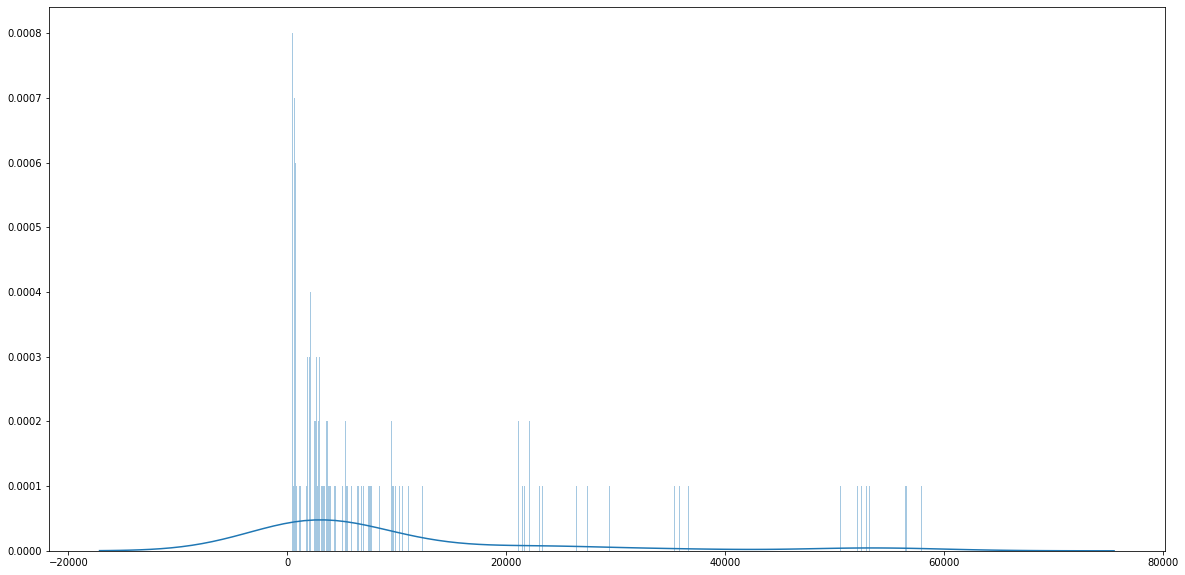

Mean: 10168.746135798; Median: 3315.42622089; Mode: 406.1543182; Standard Deviation: 14707.901018363282; kurtosis: 2.9130136522863577; Skewness: 1.9729068009392847


<Figure size 432x288 with 0 Axes>

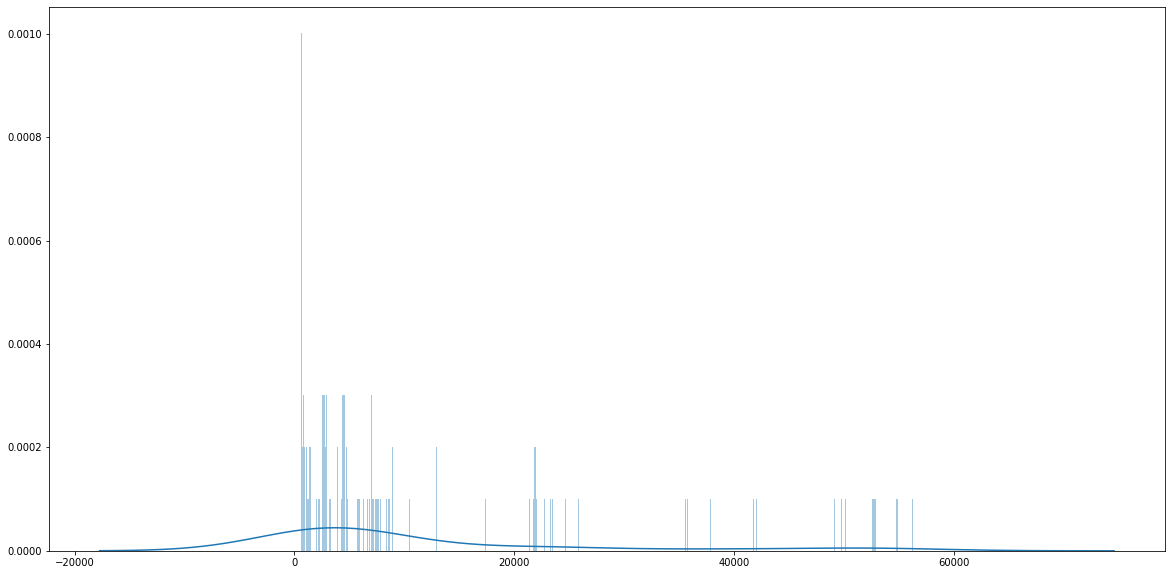

Mean: 11555.9191739291; Median: 4547.94782175; Mode: 569.3086364; Standard Deviation: 15330.98960519714; kurtosis: 1.7097184219971204; Skewness: 1.7123789622102696


<Figure size 432x288 with 0 Axes>

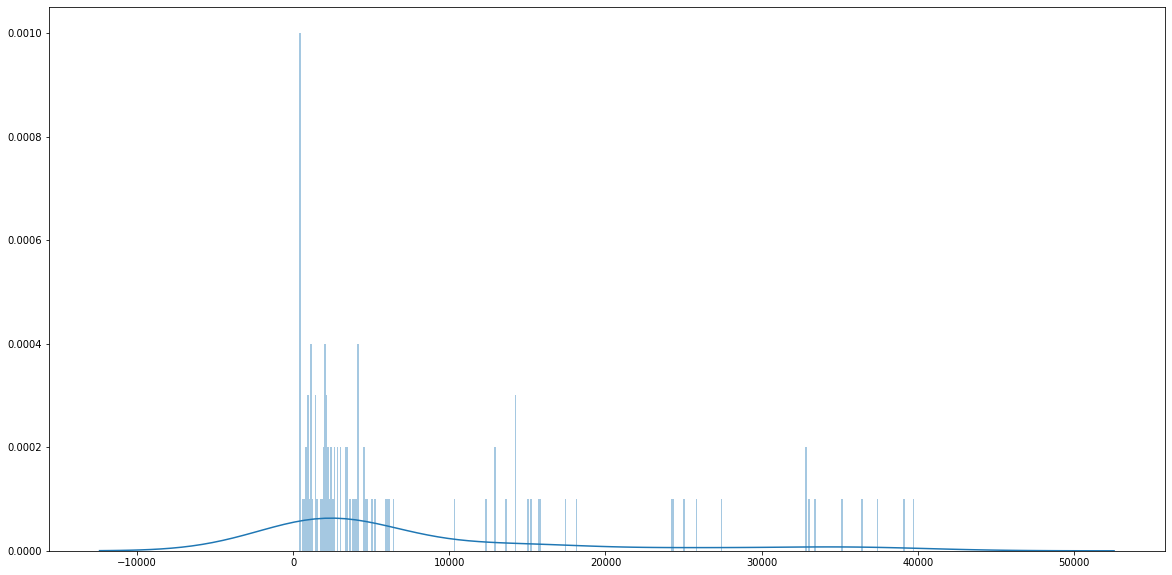

Mean: 8232.1825176461; Median: 3164.83751975; Mode: 388.1543182; Standard Deviation: 10707.412138779253; kurtosis: 1.4815894909394807; Skewness: 1.6393105750233872


<Figure size 432x288 with 0 Axes>

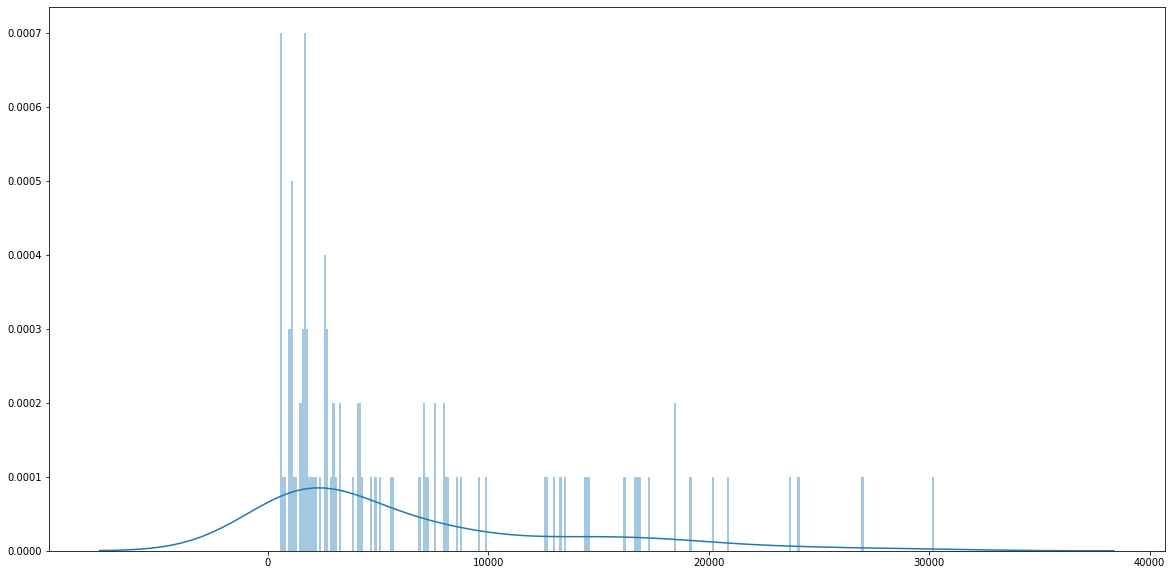

Mean: 6529.842103704001; Median: 3176.9361510999997; Mode: 1122.2689282; Standard Deviation: 6837.154953310438; kurtosis: 1.2347858008995969; Skewness: 1.4130079872298713


<Figure size 432x288 with 0 Axes>

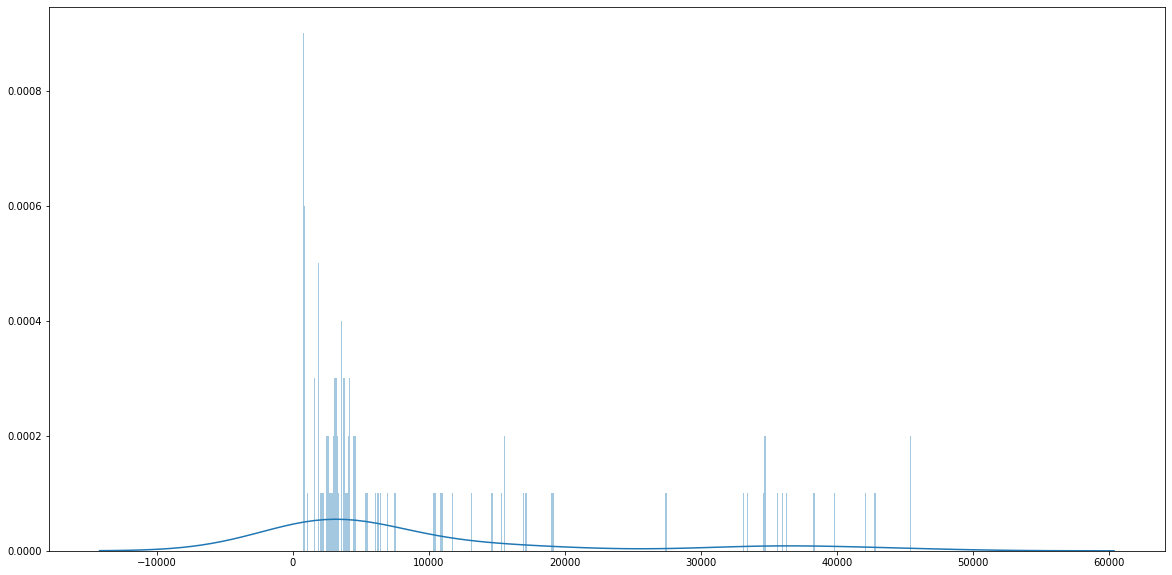

Mean: 9703.453395194201; Median: 3777.2305503000002; Mode: 714.4629545999999; Standard Deviation: 12508.010415100043; kurtosis: 1.3188741878329235; Skewness: 1.6446025952812158


<Figure size 432x288 with 0 Axes>

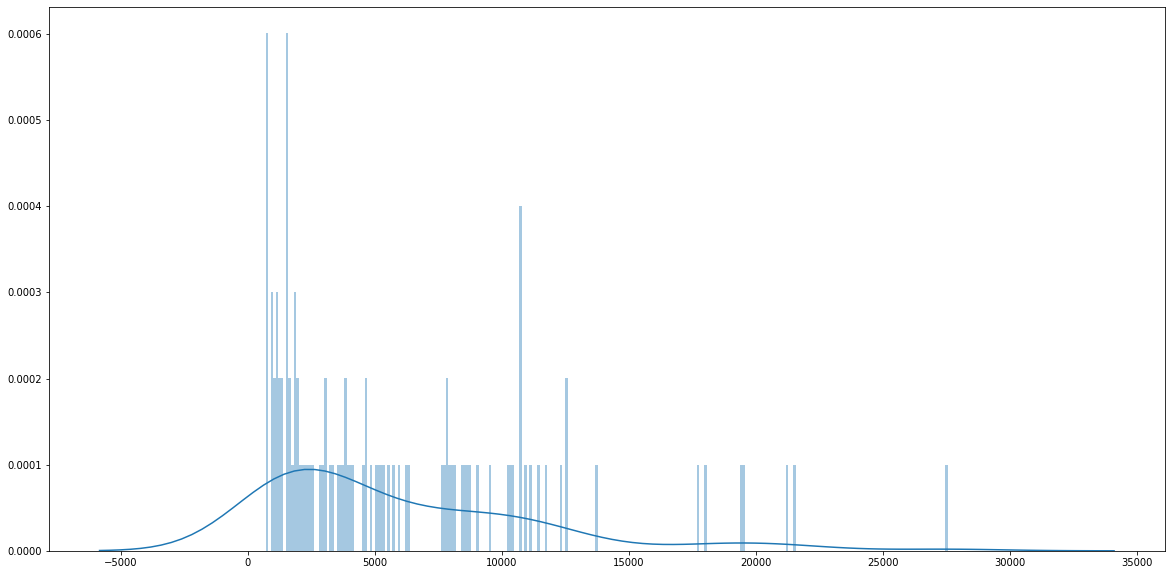

Mean: 5972.9378560064; Median: 3963.84038985; Mode: 983.8239979999998; Standard Deviation: 5471.633048879947; kurtosis: 2.243170137452956; Skewness: 1.501704958792532
[8838.18280128731, 9062.765705855247, 7269.426436031801, 5925.252975344229, 7718.592245167674, 6149.835879912165]


In [9]:
my_gambler.plot_all_arms()

print(my_bandit.true_mean_arm_rewards)

In [ ]:
epsilon_greedy_trials = []
ucb_trials = []
hyperparams = [
    {'epsilon': 0.9, 'decay': 0.0, },
    {'epsilon': 0.9, 'decay': 0.001, },
    {'epsilon': 0.9, 'decay': 0.01, },
    {'epsilon': 0.6, 'decay': 0.0, },
    {'epsilon': 0.6, 'decay': 0.001, },
    {'epsilon': 0.6, 'decay': 0.01, },
    {'epsilon': 0.3, 'decay': 0.0, },
    {'epsilon': 0.3, 'decay': 0.001, },
    {'epsilon': 0.3, 'decay': 0.01, }
]
for params in hyperparams:
    ucb_trials.append(my_gambler.epsilon_greedy(epsilon=params['epsilon'], decay=params['decay'], use_ucb=True))
    
for params in hyperparams:
    epsilon_greedy_trials.append(my_gambler.epsilon_greedy(epsilon=params['epsilon'], decay=params['decay']))

In [24]:
pickle.dump(ucb_trials, open('ucb_trials.p', 'wb'))
pickle.dump(epsilon_greedy_trials, open('epsilon_greedy_trials.p', 'wb'))